<a href="https://colab.research.google.com/github/nakul-c/LULC_Prediction/blob/main/DL_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.5 MB/s eta 0:00:00


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FEATURES = ['B1', 'B2' , 'B3' , 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A' , 'B9', 'B11', 'B12' ]
LABEL = ['Class']
SPLIT = ['sample']
N_CLASSES = 7
CLASSES = [0, 1, 2, 3, 4, 5, 6]
PALETTE = [  '#c92a0d' , '#00ffff' , '#98ff00' , '#e76cdc' , '#fcff8d' , '#887e27' , '#cbc4d6']
SAMPLE_PATH = '/content/drive/MyDrive/2022_Classification/LULC_Point_training_2022.csv'
IMAGE_PATH  = '/content/drive/MyDrive/2022_Classification/2022_sentinel_2.tif'


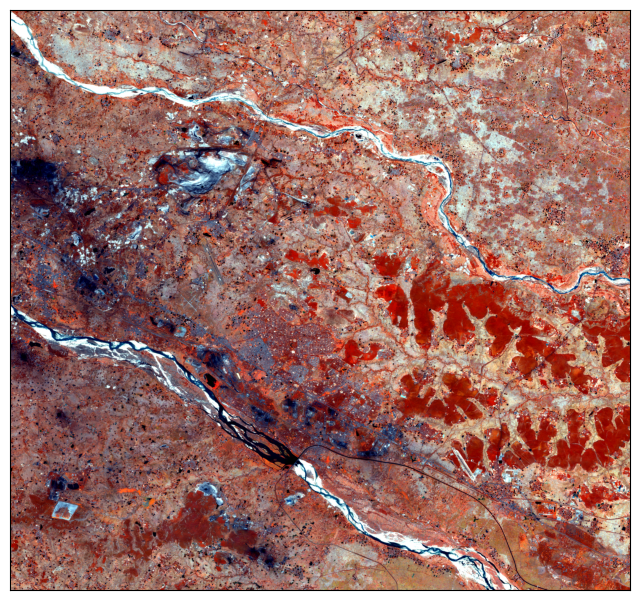

<Axes: >

In [ ]:
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [ ]:
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,Class,sample
1349,0.07025,0.09460,0.11435,0.13165,0.15020,0.16010,0.16895,0.17275,0.17840,0.19325,0.21470,0.19445,0,train
2005,0.06470,0.06765,0.08195,0.08750,0.10905,0.14450,0.15985,0.16715,0.16855,0.17225,0.15885,0.12840,0,test
2653,0.04375,0.05700,0.07760,0.07430,0.11050,0.19130,0.21175,0.23330,0.22610,0.22395,0.17260,0.11910,1,train
8750,0.06995,0.09100,0.12225,0.15970,0.19580,0.22830,0.25125,0.26635,0.28025,0.28220,0.36255,0.27760,4,test
8693,0.05185,0.06080,0.08185,0.09355,0.13000,0.17675,0.19320,0.21115,0.21665,0.22695,0.21340,0.14895,4,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8613,0.04950,0.06140,0.08540,0.09450,0.13220,0.17890,0.19570,0.20900,0.22030,0.22410,0.24720,0.18040,4,train
7968,0.05105,0.06635,0.09860,0.11245,0.16965,0.23220,0.25650,0.27060,0.28210,0.27210,0.28775,0.20465,4,train
9238,0.05230,0.06900,0.09370,0.10470,0.13870,0.18050,0.19745,0.20805,0.21130,0.21535,0.23955,0.19010,4,test
5067,0.11310,0.18505,0.14655,0.18280,0.31245,0.31875,0.32660,0.32075,0.30745,0.26215,0.16540,0.35815,3,train


In [ ]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1, int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (9436, 12, 1)
Test features: (2245, 12, 1)
Train label: (9436, 8)
Test label: (2245, 8)


In [ ]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 256
drop = 0.2
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11, 256)           768       
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 256)           131328    
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 256)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 512)            262656    
                                                                 
 conv1d_3 (Conv1D)           (None, 3, 512)            524800    
                                                        

In [ ]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
10/10 [==============================] - 9s 128ms/step - loss: 1.9600 - accuracy: 0.2155 - val_loss: 1.8870 - val_accuracy: 0.2303
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 1.7929 - accuracy: 0.2394 - val_loss: 1.7310 - val_accuracy: 0.2410
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 1.5615 - accuracy: 0.3888 - val_loss: 1.4936 - val_accuracy: 0.4944
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 1.3904 - accuracy: 0.5095 - val_loss: 1.2635 - val_accuracy: 0.6374
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 1.1662 - accuracy: 0.6121 - val_loss: 1.0268 - val_accuracy: 0.6735
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 1.0300 - accuracy: 0.6477 - val_loss: 0.9837 - val_accuracy: 0.6900
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 0.9632 - accuracy: 0.6747 - val_loss: 0.9025 - val_accuracy: 0.7118
Epoch

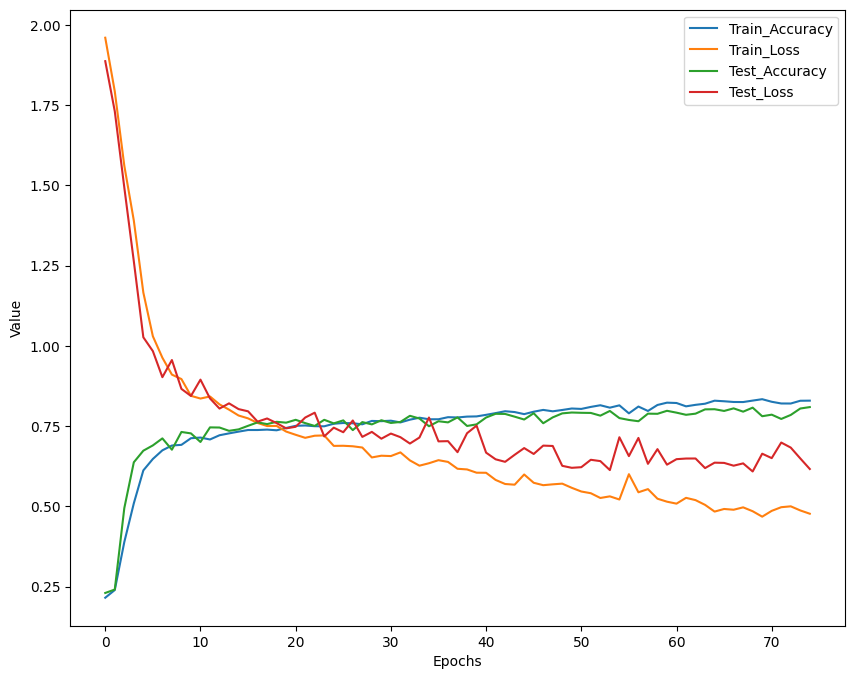

In [ ]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

71/71 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       451
           1       0.80      0.38      0.52       175
           2       0.95      0.89      0.92       386
           3       0.84      0.84      0.84       250
           4       0.85      0.98      0.91       598
           5       0.87      0.71      0.78       211
           6       0.44      0.39      0.42       174

    accuracy                           0.81      2245
   macro avg       0.78      0.72      0.74      2245
weighted avg       0.81      0.81      0.80      2245



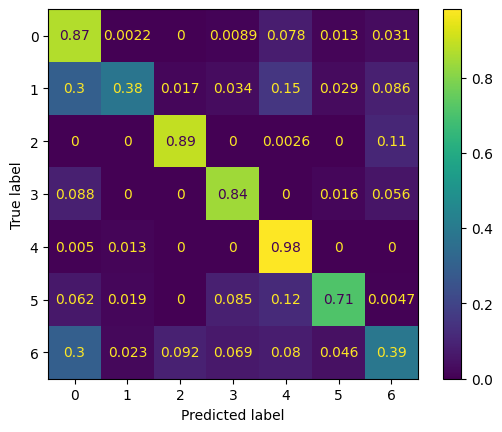

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

297/297 [==============================] - 110s 344ms/step


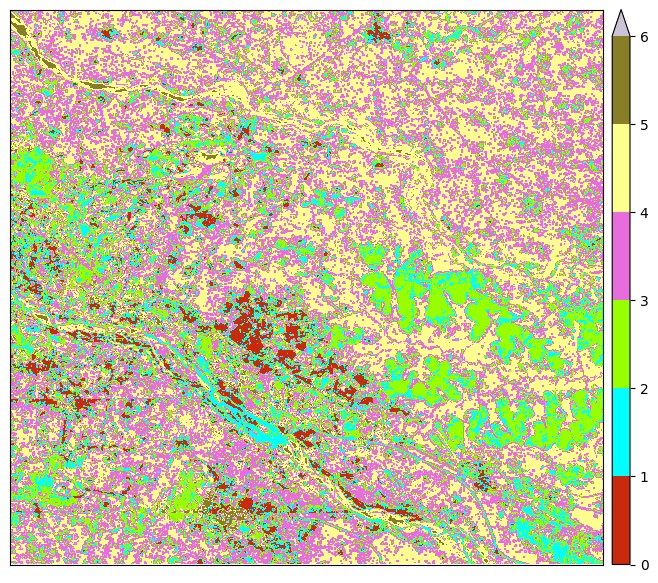

<Axes: >

In [ ]:
image_input = []
for x in range(12):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(12, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

In [ ]:
# Save file to drive
save_location = '/content/drive/MyDrive/2022_Classification/'
name = 'LC_Durgapur_2022.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=rasterio.uint8,
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()